## 1.Project introduction

- This dataset contains weekly sales from 99 departments belonging to 45 different stores. 
- Our aim is to forecast weekly sales from a particular department.
- The objective of this case study is to forecast weekly retail store sales based on historical data.
- The data contains holidays and promotional markdowns offered by various stores and several departments throughout the year.
- Markdowns are crucial to promote sales especially before key events such as Super Bowl, Christmas and Thanksgiving. 
- Developing accurate model will enable make informed decisions and make recommendations to improve business processes in the future. 
- The data consists of three sheets: 
    - Stores
    - Features
    - Sales
- Data Source : https://www.kaggle.com/manjeetsingh/retaildataset

## 2.Import data and libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/Project/Walmart Sales Prediction")
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 ANN_TEST.ipynb		'Sales Prediction using XGBoost in AWS SageMaker.ipynb'
'back up.ipynb'		 stores_data_set.csv
 Features_data_set.csv	 udemy.ipynb
 sales_data_set.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Import the csv file using pandas
feature = pd.read_csv('Features_data_set.csv')
sales = pd.read_csv('sales_data_set.csv')
stores = pd.read_csv('stores_data_set.csv')

### 2.1stores

In [4]:
# "stores" dataframe contains information related to the 45 stores such as type and size of store.
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


### 2.1feature

Features dataframe contains additional data related to the store, department, and regional activity for the given dates.

* Store: store number
* Date: week
* Temperature: average temperature in the region
* Fuel_Price: cost of fuel in the region
* MarkDown1-5: anonymized data related to promotional markdowns. 
* CPI: consumer price index
* Unemployment: unemployment rate
* IsHoliday: whether the week is a special holiday week or not

In [5]:
feature.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,26/07/2013,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


### 2.3sales

"Sales" dataframe contains historical sales data, which covers 2010-02-05 to 2012-11-01. 
* Store: store number
* Dept: department number
* Date: the week
* Weekly_Sales: sales for the given department in the given store
* IsHoliday: whether the week is a special holiday week

In [6]:
# We have over 42 thousand record here
sales.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,28/09/2012,508.37,False
421566,45,98,05/10/2012,628.10,False
421567,45,98,12/10/2012,1061.02,False
421568,45,98,19/10/2012,760.01,False
421569,45,98,26/10/2012,1076.80,False


In [7]:
# Change the datatype of 'date' column 
feature['Date'] = pd.to_datetime(feature['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

## 3.Merge and Feature Engieering

In [8]:
feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [9]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [10]:
df = pd.merge(sales, feature, on = ['Store','Date','IsHoliday'])
df.head() 

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-05-02,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-05-02,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-05-02,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-05-02,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
df = pd.merge(df, stores, on = ['Store'], how = 'left')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-05-02,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-05-02,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-05-02,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-05-02,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [13]:
# Add column for year
df["Year"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.year

# Add column for day
df["Day"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.day

# Add column for day
df["Month"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.month

# Add column for days to next Christmas
df["Days to Next Christmas"] = (pd.to_datetime(df["Year"].astype(str)+"-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
# Add column for day of the week
df['dayofweek']= pd.to_datetime(df['Date']).dt.dayofweek

# Drop the origin date column
df = df.drop(['Date'], axis= 1)

df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Day,Month,Days to Next Christmas,dayofweek
0,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,243,6
1,1,2,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,243,6
2,1,3,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,243,6
3,1,4,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,243,6
4,1,5,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5,243,6


In [14]:
# Check the NA values Eveluation
df.isnull().sum()

Store                          0
Dept                           0
Weekly_Sales                   0
IsHoliday                      0
Temperature                    0
Fuel_Price                     0
MarkDown1                 270889
MarkDown2                 310322
MarkDown3                 284479
MarkDown4                 286603
MarkDown5                 270138
CPI                            0
Unemployment                   0
Type                           0
Size                           0
Year                           0
Day                            0
Month                          0
Days to Next Christmas         0
dayofweek                      0
dtype: int64

In [15]:
# Fill NA values with zeros
df = df.fillna(0)

In [16]:
# Check the number of duplicated entries in the dataframe
df.duplicated().sum()

0

In [17]:
df['Type'].value_counts(normalize = True)

A    0.511132
B    0.387824
C    0.101044
Name: Type, dtype: float64

It seems like Type A is the most prevalent type of store, more than half of the stores belongs to Type A.

In [18]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Day,Month,Days to Next Christmas,dayofweek
0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
1,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
2,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
3,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
4,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6


In [19]:
# Convert the 'IsHoliday' from characters into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# IsHoliday
le.fit(df.IsHoliday.drop_duplicates())
df.IsHoliday = le.transform(df.IsHoliday)

In [20]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Day,Month,Days to Next Christmas,dayofweek
0,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
1,1,2,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
2,1,3,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
3,1,4,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
4,1,5,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6


##  4.Exploratory Data Analysis

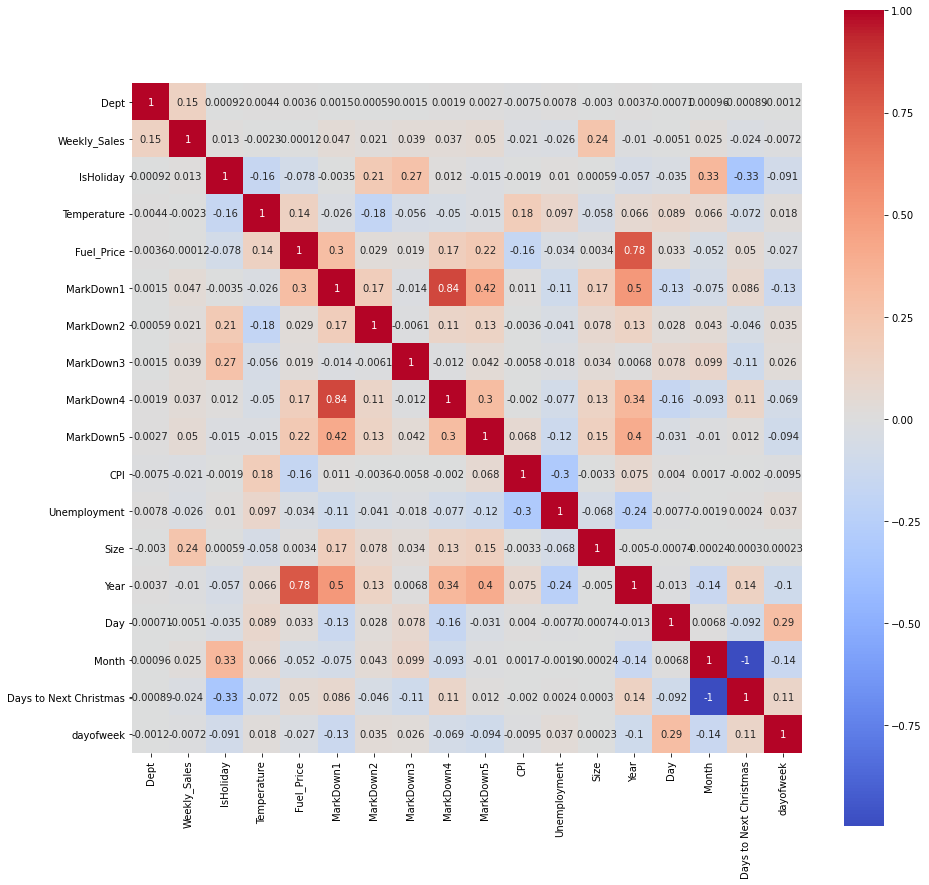

In [21]:
corr_matrix = df.drop(columns = ['Store']).corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, cmap = 'coolwarm',annot = True,square = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc472eda20>,
      dtype=object)

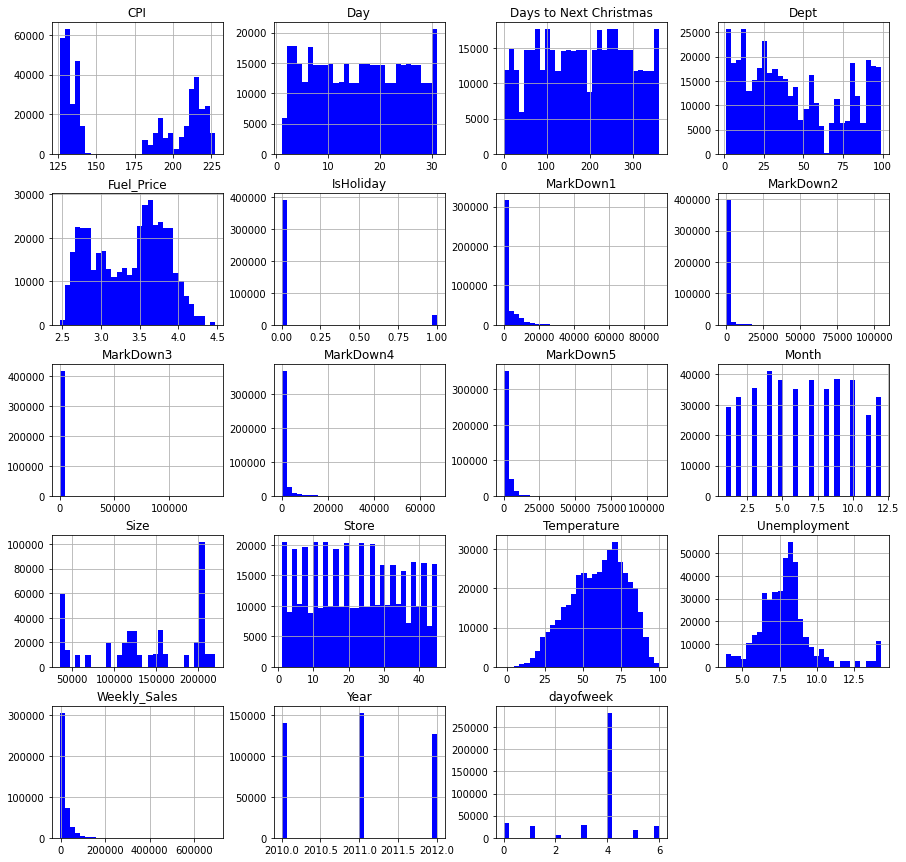

In [22]:
df.hist(bins = 30, figsize = (15,15), color = 'b')

In [23]:
df_type = df.groupby('Type').mean()
df_type

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Day,Month,Days to Next Christmas,dayofweek
Type,,,,,,,,,,,,,,,,,,,
A,21.736419,44.622156,20099.568043,0.070471,60.531945,3.343999,3102.403194,1083.216159,549.644930,1325.891281,2147.830168,174.408895,7.791595,182231.285486,2010.966683,15.639040,6.480030,183.565422,3.571529
B,18.450417,43.112273,12237.075977,0.070412,57.562951,3.382523,2553.465968,827.500452,481.215226,1043.927675,1324.921913,167.176656,7.928836,101818.735827,2010.967858,15.650148,6.478100,183.613046,3.572751
C,38.942015,46.836350,9519.532538,0.069582,67.554266,3.364654,138.960203,53.274338,5.142226,5.603993,505.826631,170.429314,8.934350,40535.725286,2010.981055,15.646102,6.473085,183.772848,3.569876


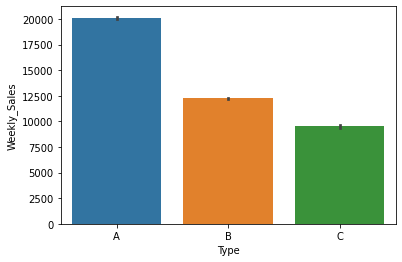

In [24]:
# Visulaze the Sales by the stores
sns.barplot(x = df['Type'], y = df['Weekly_Sales'], data = df)

## 5.Prepare the data before training

In [25]:
# Drop the dataset
df_target = df['Weekly_Sales']
df_final = df.drop(columns = ['Weekly_Sales'])

In [26]:
df_final.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Day,Month,Days to Next Christmas,dayofweek
0,1,1,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
1,1,2,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
2,1,3,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
3,1,4,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6
4,1,5,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,243,6


In [27]:
# Convert the categorical columns into numeric
df_final = pd.get_dummies(df_final, columns = ['Type','Store','Dept'], drop_first = True)

In [28]:
df_final.shape

(421570, 142)

In [29]:
df_target.shape

(421570,)

In [30]:
X = np.array(df_final).astype('float32')
y = np.array(df_target).astype('float32')

In [31]:
# Reshaping the array from (421570, ) to (421570, 1 )
y_reshape = y.reshape(-1,1)
y_reshape.shape

(421570, 1)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
X_scale = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_scale = scaler_y.fit_transform(y_reshape)

Scaling does't make much sense for XGBoost, but we scale it since other linear model may get affected.

In [33]:
# spliting the data in to test and train sets
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size = 0.2,random_state = 42)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.3)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(337256, 142)
(84314, 142)
(337256, 1)
(84314, 1)


## 6.Linear Regression(degree = 1)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score
from math import sqrt

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_R2 = lr.score(X_test,y_test)
lr_R2

0.6523352694859081

In [36]:
# Predict the value
y_pred = lr.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [37]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 13519.47 
MSE = 182776060.0 
MAE = 8186.331 
R2= 0.6523352776846965 
Adjusted R2 = 0.6517528901229603


## 7.Deep Learning Model (ANN)

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [39]:
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 142))
ANN_model.add(Activation('relu'))

ANN_model.add(Dense(200))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.25))

ANN_model.add(Dense(200))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.25))

ANN_model.add(Dense(100))
ANN_model.add(Activation('linear'))

ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                7150      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0

In [40]:
# Compile the model and trainning
ANN_model.compile(optimizer= 'Adam', loss='mean_squared_error')
epochs_hist = ANN_model.fit(X_train, y_train, epochs= 20, batch_size = 1000, validation_split= 0.3)

result = ANN_model.evaluate(X_test, y_test)
accuracy_ANN = 1 - result
print('Accuracy : {}'.format(accuracy_ANN) )

Epoch 1/20
237/237 [==============================] - 6s 24ms/step - loss: 0.3078 - val_loss: 0.1176
Epoch 2/20
237/237 [==============================] - 5s 23ms/step - loss: 0.1273 - val_loss: 0.0879
Epoch 3/20
237/237 [==============================] - 5s 23ms/step - loss: 0.1086 - val_loss: 0.0805
Epoch 4/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0924 - val_loss: 0.0781
Epoch 5/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0878 - val_loss: 0.0777
Epoch 6/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0805 - val_loss: 0.0736
Epoch 7/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0771 - val_loss: 0.0779
Epoch 8/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0733 - val_loss: 0.0720
Epoch 9/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0688 - val_loss: 0.0733
Epoch 10/20
237/237 [==============================] - 5s 23ms/step - loss: 0.0677 - val_lo

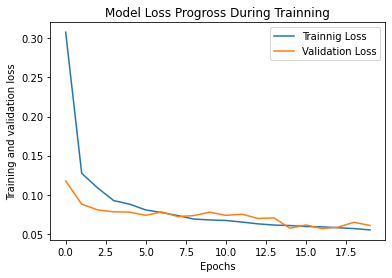

In [41]:
epochs_hist.history.keys()
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progross During Trainning')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
plt.legend(['Trainnig Loss','Validation Loss'])

Text(0, 0.5, 'True Values')

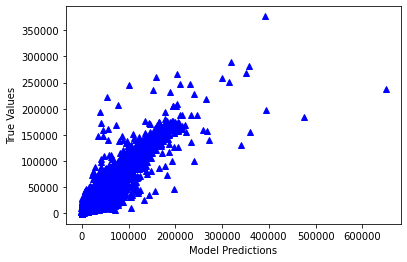

In [43]:
# change the color
y_pred = ANN_model.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

plt.plot(y_test_orig, y_pred_orig, "^", color = 'b')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [44]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 5880.592 
MSE = 34581364.0 
MAE = 3169.0022 
R2= 0.9342215835923947 
Adjusted R2 = 0.9341113954453449


## 8.XGBoost by GridSerch

In [52]:
param_grid = {
        'gamma': [0.1, 0.5, 1],   # regularization parameter 
        'max_depth': [4, 5, 6] # depth of each tree
        }

xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')

grid_xgb = GridSearchCV(xgb_model,
                    param_grid,
                    cv = 3, 
                    n_jobs = -1, 
                    verbose = 4)

In [53]:
grid_xgb.fit(X_train, y_train)

grid_xgb.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 46.1min finished


{'gamma': 0.5, 'max_depth': 6}

In [54]:
grid_xgb_R2 = grid_xgb.score(X_test,y_test)
grid_xgb_R2

0.8475530684581727

In [55]:
# Predict the value
y_pred = grid_xgb.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [56]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 8952.384 
MSE = 80145180.0 
MAE = 5801.3457 
R2= 0.8475530758330183 
Adjusted R2 = 0.8472977056825224
